# Présentation 

In [1]:
%%capture
%run '4 - Analyse.ipynb'
%run '5 - Modèles.ipynb'

## 1 - Introduction

  - [TTFL](https://fantasy.trashtalk.co/login/)
  - [NBA Statistiques](https://www.nba.com/stats/)
  
## 2 - Construction de la base

In [2]:
def get_data_box(saison):
    '''Récupère les boxscores de tous les matchs de tous les joueurs
    qui ont joué pendant la saison
    ''' 
    
    df = pd.DataFrame()
    id_actives = active_players(saison)

    wait_time = len(id_actives)*0.7
    
    print(f'Cela va prendre environ : {datetime.timedelta(seconds=wait_time)}')
    for i in range(len(id_actives)):
        print(f'\r{i+1}/{len(id_actives)}', end='')
        
        df = df.append(boxscore_saison(id_actives[i], saison))
        time.sleep(0.5)
        
    df.to_csv(f'../data/boxscore_{saison}.csv', index=False)

- [Score](https://trashtalk.co/2019/10/20/le-guide-officiel-pour-bien-debuter-en-ttfl-par-ici-pour-se-lancer-dans-la-trashtalk-fantasy-league/)

In [3]:
def score_df(stats):
    '''Met en forme et calcul le score de la base de donnée que l'on récupère 
    par le endpoint PlayerGameLog
    '''
    
    stats = stats.assign(GAME_DATE=pd.to_datetime(stats['GAME_DATE']),
                         TEAM=lambda df: df['MATCHUP'].str[:3],
                         ADV=lambda df: df['MATCHUP'].str[-3:],
                         HOME=lambda df: ~df['MATCHUP'].str.contains('@'),
                         WIN=lambda df: df['WL'].map({'W':True, 'L':False}),
                         FGF=lambda df: df['FGA'] - df['FGM'],
                         FG3F=lambda df: df['FG3A'] - df['FG3M'],
                         FTF=lambda df: df['FTA'] - df['FTM'])
    
    bonus = ['PTS', 'REB', 'AST', 'STL', 'BLK', 'FGM', 'FTM', 'FG3M']
    malus = ['TOV', 'FGF', 'FG3F', 'FTF']

    cols = stats.columns.tolist()
    stats = stats[cols[:4] + cols[-7:-3] + bonus + malus]
    
    stats = stats.assign(BONUS=lambda df: df[bonus].sum(axis=1).astype('int'),
                         MALUS=lambda df: df[malus].sum(axis=1).astype('int'),
                         SCORE=lambda df: df['BONUS'] - df['MALUS'])
    
    #Cohérence des noms de colones
    stats.rename(columns={'Player_ID': 'PLAYER_ID', 'Game_ID': 'GAME_ID'}, 
                 inplace=True)
    
    #On mets l'ordre par rapport au joueur puis par dates
    stats.sort_values(['PLAYER_ID', 'GAME_DATE'], inplace=True)

    return(stats.reset_index(drop=True))

In [4]:
df = players_id2name(score_df(pd.read_csv('../data/boxscore_2019.csv')))
df.sample(3)

,SEASON_ID,PLAYER_ID,NAME,GAME_ID,GAME_DATE,TEAM,ADV,HOME,WIN,PTS,REB,AST,STL,BLK,FGM,FTM,FG3M,TOV,FGF,FG3F,FTF,BONUS,MALUS,SCORE
19495,22019,1629001,De'Anthony Melton,21901262,2020-08-05,MEM,UTA,False,False,5,3,1,0,0,2,1,0,1,8,4,1,12,14,-2
4091,22019,202355,Hassan Whiteside,21900193,2019-11-18,POR,HOU,False,False,11,8,2,1,2,5,1,0,3,4,0,0,30,7,23
23846,22019,1629740,Nicolo Melli,21900780,2020-02-08,NOP,IND,False,True,9,6,1,0,1,3,0,3,0,5,2,0,23,7,16


In [5]:
def avg_df(df, n=N):
    '''Calcul les moyennes en utilisant une 'rolling window' sur les variables 
    intéressantes
    
    Args :
        df : database avec les variables dans list_var_avg
        
    '''
    
    def avg(df):
        return df[list_var_avg].shift(periods=1)  \
                                .rolling(n)  \
                                .mean()  \
                                .add_prefix('AVG_')
                                
    
    # Calcul des moyennes pour chaque joueur puis on recréer une base
    df_mean = df.groupby('PLAYER_ID').apply(avg)  \
                                        .reset_index()  \
                                        .set_index('level_1')  \

    return pd.concat([df, df_mean.drop('PLAYER_ID', axis=1)], axis=1)

In [6]:
avg_df(df).sample(3)

,SEASON_ID,PLAYER_ID,NAME,GAME_ID,GAME_DATE,TEAM,ADV,HOME,WIN,PTS,REB,AST,STL,BLK,FGM,FTM,FG3M,TOV,FGF,FG3F,FTF,BONUS,MALUS,SCORE,AVG_PTS,AVG_REB,AVG_AST,AVG_STL,AVG_BLK,AVG_FGM,AVG_FTM,AVG_FG3M,AVG_TOV,AVG_FGF,AVG_FG3F,AVG_FTF,AVG_BONUS,AVG_MALUS,AVG_SCORE
9374,22019,203914,Gary Harris,21900559,2020-01-08,DEN,DAL,False,True,9,0,0,3,0,3,3,0,1,5,3,1,18,10,8,7.666667,3.666667,2.333333,0.666667,0.0,3.000000,1.000000,0.666667,1.333333,7.0,3.666667,0.000000,19.000000,12.000000,7.0
22793,22019,1629645,Kevin Porter Jr.,21900395,2019-12-16,CLE,TOR,False,False,9,1,4,0,0,3,2,1,1,4,2,0,20,7,13,14.666667,1.333333,2.333333,1.666667,0.0,5.000000,2.000000,2.666667,1.333333,5.0,2.666667,0.666667,29.666667,9.666667,20.0
13923,22019,1627759,Jaylen Brown,21900222,2019-11-22,BOS,DEN,False,False,22,10,4,1,0,6,6,4,1,9,3,2,53,15,38,13.666667,7.666667,1.333333,1.333333,0.0,5.333333,0.666667,2.333333,2.666667,10.0,4.333333,1.333333,32.333333,18.333333,14.0


In [7]:
players_id2name(pd.read_csv('../data/boxscore_2019_final.csv')).sample(3)

,SEASON_ID,PLAYER_ID,NAME,GAME_ID,GAME_DATE,TEAM,ADV,HOME,WIN,PTS,REB,AST,STL,BLK,FGM,FTM,FG3M,TOV,FGF,FG3F,FTF,BONUS,MALUS,SCORE,AVG_PTS,AVG_REB,AVG_AST,AVG_STL,AVG_BLK,AVG_FGM,AVG_FTM,AVG_FG3M,AVG_TOV,AVG_FGF,AVG_FG3F,AVG_FTF,AVG_BONUS,AVG_MALUS,AVG_SCORE,AVG_ADD_PTS,AVG_ADD_REB,AVG_ADD_AST,AVG_ADD_STL,AVG_ADD_BLK,AVG_ADD_FGM,AVG_ADD_FTM,AVG_ADD_FG3M,AVG_ADD_TOV,AVG_ADD_FGF,AVG_ADD_FG3F,AVG_ADD_FTF,AVG_ADD_BONUS,AVG_ADD_MALUS,AVG_ADD_SCORE,NB_VIC,NB_VIC_ADD
9803,22019,203926,Doug McDermott,21900474,2019-12-28,IND,NOP,False,False,9,2,0,0,0,4,0,1,2,5,3,0,16,10,6,12.333333,2.000000,1.666667,0.333333,0.000000,4.333333,0.666667,3.000000,0.333333,4.333333,3.666667,0.000000,24.333333,8.333333,16.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
12242,22019,1626179,Terry Rozier,21900793,2020-02-10,CHA,DET,False,True,11,7,2,0,0,4,2,1,2,9,5,0,27,16,11,17.666667,4.666667,2.333333,0.000000,0.666667,6.000000,3.000000,2.666667,1.666667,7.666667,4.666667,0.333333,37.000000,14.333333,22.666667,23.0,4.0,2.0,2.0,0.0,8.0,1.0,6.0,0.0,7.0,3.0,0.0,46.0,10.0,36.0,0,3
5895,22019,203082,Terrence Ross,21900308,2019-12-04,ORL,PHX,True,True,22,3,1,2,0,7,5,3,2,7,3,0,43,12,31,13.333333,2.333333,1.000000,0.666667,1.000000,5.000000,1.333333,2.000000,0.666667,5.666667,3.666667,0.666667,26.666667,10.666667,16.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,0


## 3 - Analyse

Reprenons le cheminement d'un joueur.

In [8]:
# Classement des joueurs en fonction de leur meilleurs performances
df.groupby('NAME').SCORE.max().sort_values(ascending=False)  \
                                    .head(5)  \
                                    .to_frame()

,SCORE
NAME,
James Harden,97
Damian Lillard,93
Kyrie Irving,89
Joel Embiid,88
Khris Middleton,87


In [9]:
giannis=df[df.NAME == 'Giannis Antetokounmpo']

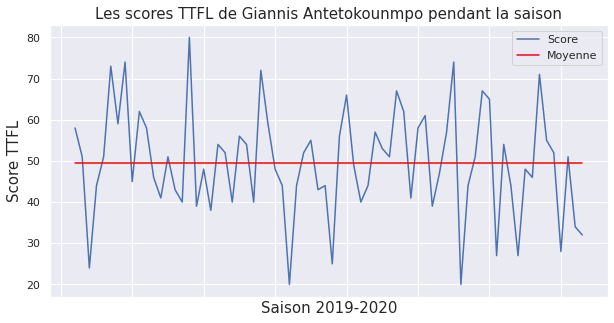

In [10]:
plt.figure(figsize=(10,5))

# Le score de Giannis au cours de la saison
plt.plot(giannis.index,giannis.SCORE,label='Score')

# Le score moyen de Giannis au cours de la saison
plt.plot(giannis.index, np.repeat(giannis.SCORE.mean(),len(giannis)), 
         color='red', linestyle='solid', label='Moyenne')

plt.title(label='Les scores TTFL de Giannis Antetokounmpo pendant la saison',
          fontsize=15)
plt.ylabel(ylabel='Score TTFL',fontsize=15)
plt.xlabel(xlabel='Saison 2019-2020',fontsize=15)

plt.tick_params(labelbottom=False) 
plt.legend()

plt.show()

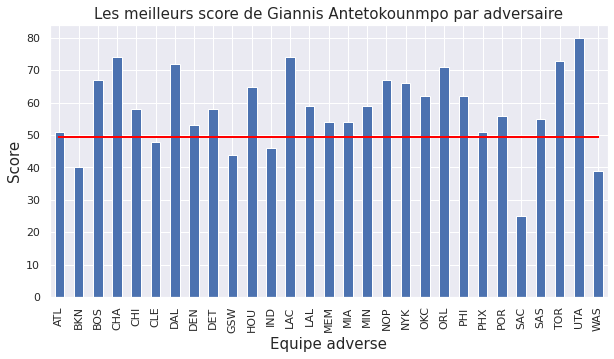

In [11]:
plt.figure(figsize=(10,5))

# Score maximum de Giannis par adversaire
giannis.groupby('ADV').SCORE.max().plot(kind='bar',figsize=(10,5),
                                        label='Score maximum')

# Score maximum de Giannis par adversaire
plt.plot(giannis.ADV, np.repeat(giannis.SCORE.mean(),len(giannis)),
         color='red', linestyle='solid', label='Score moyen')

plt.title('Les meilleurs score de Giannis Antetokounmpo par adversaire',
            fontsize=15)

plt.ylabel(ylabel='Score',fontsize=15)
plt.xlabel(xlabel='Equipe adverse',fontsize=15)

plt.show()

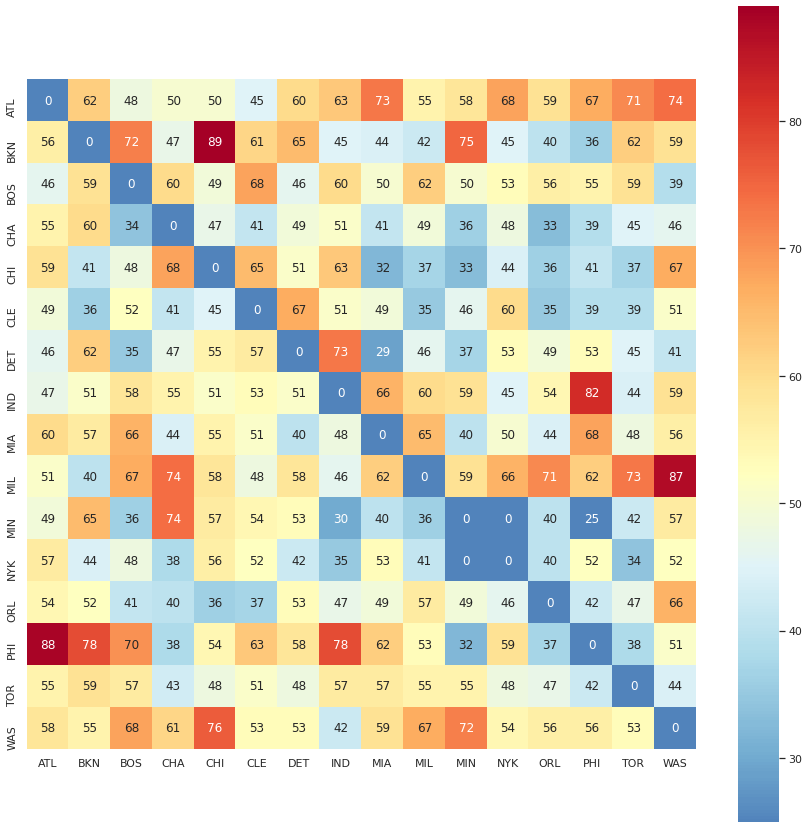

In [12]:
heatmap(cross_east)

## 4 - Modèles

In [13]:
df_model.sample(3)

,GAME_DATE,HOME,SCORE,AVG_PTS,AVG_REB,AVG_AST,AVG_STL,AVG_BLK,AVG_FGM,AVG_FTM,AVG_FG3M,AVG_TOV,AVG_FGF,AVG_FG3F,AVG_FTF,NB_VIC,NB_VIC_ADD,PLAYER_ID_1713,PLAYER_ID_2199,PLAYER_ID_2544,PLAYER_ID_2546,PLAYER_ID_2594,PLAYER_ID_2617,PLAYER_ID_2730,PLAYER_ID_2738,PLAYER_ID_2747,PLAYER_ID_2772,PLAYER_ID_101107,PLAYER_ID_101108,PLAYER_ID_101133,PLAYER_ID_101139,PLAYER_ID_101141,PLAYER_ID_101150,PLAYER_ID_200746,PLAYER_ID_200752,PLAYER_ID_200755,PLAYER_ID_200757,PLAYER_ID_200765,PLAYER_ID_200768,PLAYER_ID_200782,PLAYER_ID_200794,PLAYER_ID_200826,PLAYER_ID_201143,PLAYER_ID_201144,PLAYER_ID_201145,PLAYER_ID_201147,PLAYER_ID_201149,PLAYER_ID_201152,PLAYER_ID_201158,PLAYER_ID_201162,PLAYER_ID_201163,PLAYER_ID_201188,PLAYER_ID_201229,PLAYER_ID_201565,PLAYER_ID_201566,PLAYER_ID_201567,PLAYER_ID_201568,PLAYER_ID_201569,PLAYER_ID_201571,PLAYER_ID_201572,PLAYER_ID_201577,PLAYER_ID_201580,PLAYER_ID_201584,PLAYER_ID_201586,PLAYER_ID_201587,PLAYER_ID_201588,PLAYER_ID_201599,PLAYER_ID_201609,PLAYER_ID_201933,PLAYER_ID_201935,PLAYER_ID_201937,PLAYER_ID_201939,PLAYER_ID_201942,PLAYER_ID_201949,PLAYER_ID_201950,PLAYER_ID_201952,PLAYER_ID_201959,PLAYER_ID_201960,PLAYER_ID_201961,PLAYER_ID_201976,PLAYER_ID_201980,PLAYER_ID_201988,PLAYER_ID_202066,PLAYER_ID_202083,PLAYER_ID_202323,PLAYER_ID_202324,PLAYER_ID_202329,PLAYER_ID_202330,PLAYER_ID_202331,PLAYER_ID_202334,PLAYER_ID_202335,PLAYER_ID_202339,PLAYER_ID_202340,PLAYER_ID_202355,PLAYER_ID_202357,PLAYER_ID_202397,PLAYER_ID_202498,PLAYER_ID_202681,PLAYER_ID_202683,PLAYER_ID_202684,PLAYER_ID_202685,PLAYER_ID_202687,PLAYER_ID_202688,PLAYER_ID_202689,PLAYER_ID_202692,PLAYER_ID_202693,PLAYER_ID_202694,PLAYER_ID_202695,PLAYER_ID_202696,PLAYER_ID_202697,PLAYER_ID_202699,PLAYER_ID_202704,PLAYER_ID_202709,PLAYER_ID_202710,PLAYER_ID_202711,PLAYER_ID_202718,PLAYER_ID_202722,PLAYER_ID_202734,PLAYER_ID_202738,PLAYER_ID_202954,PLAYER_ID_203076,PLAYER_ID_203077,PLAYER_ID_203078,PLAYER_ID_203079,PLAYER_ID_203081,PLAYER_ID_203082,PLAYER_ID_203083,PLAYER_ID_203084,PLAYER_ID_203085,PLAYER_ID_203086,PLAYER_ID_203087,PLAYER_ID_203089,PLAYER_ID_203090,PLAYER_ID_203095,PLAYER_ID_203107,PLAYER_ID_203109,PLAYER_ID_203110,PLAYER_ID_203114,PLAYER_ID_203115,PLAYER_ID_203118,PLAYER_ID_203124,PLAYER_ID_203145,PLAYER_ID_203200,PLAYER_ID_203210,PLAYER_ID_203382,PLAYER_ID_203457,PLAYER_ID_203458,PLAYER_ID_203459,PLAYER_ID_203460,PLAYER_ID_203463,PLAYER_ID_203468,PLAYER_ID_203469,PLAYER_ID_203471,PLAYER_ID_203473,PLAYER_ID_203476,PLAYER_ID_203482,PLAYER_ID_203484,PLAYER_ID_203486,PLAYER_ID_203487,PLAYER_ID_203488,PLAYER_ID_203490,PLAYER_ID_203493,PLAYER_ID_203496,PLAYER_ID_203497,PLAYER_ID_203500,PLAYER_ID_203501,PLAYER_ID_203503,PLAYER_ID_203504,PLAYER_ID_203506,PLAYER_ID_203507,PLAYER_ID_203516,PLAYER_ID_203521,PLAYER_ID_203524,PLAYER_ID_203526,PLAYER_ID_203552,PLAYER_ID_203584,PLAYER_ID_203585,PLAYER_ID_203648,PLAYER_ID_203658,PLAYER_ID_203705,PLAYER_ID_203894,PLAYER_ID_203895,PLAYER_ID_203897,PLAYER_ID_203901,PLAYER_ID_203903,PLAYER_ID_203914,PLAYER_ID_203915,PLAYER_ID_203918,PLAYER_ID_203920,PLAYER_ID_203922,PLAYER_ID_203924,PLAYER_ID_203925,PLAYER_ID_203926,PLAYER_ID_203932,PLAYER_ID_203933,PLAYER_ID_203935,PLAYER_ID_203937,PLAYER_ID_203939,PLAYER_ID_203943,PLAYER_ID_203944,PLAYER_ID_203952,PLAYER_ID_203953,PLAYER_ID_203954,PLAYER_ID_203957,PLAYER_ID_203960,PLAYER_ID_203967,PLAYER_ID_203991,PLAYER_ID_203992,PLAYER_ID_203994,PLAYER_ID_203998,PLAYER_ID_203999,PLAYER_ID_204001,PLAYER_ID_204020,PLAYER_ID_204025,PLAYER_ID_204038,PLAYER_ID_204060,PLAYER_ID_204456,PLAYER_ID_1626143,PLAYER_ID_1626144,PLAYER_ID_1626145,PLAYER_ID_1626147,PLAYER_ID_1626149,PLAYER_ID_1626153,PLAYER_ID_1626156,PLAYER_ID_1626157,PLAYER_ID_1626158,PLAYER_ID_1626159,PLAYER_ID_1626161,PLAYER_ID_1626162,PLAYER_ID_1626163,PLAYER_ID_1626164,PLAYER_ID_1626166,PLAYER_ID_1626167,PLAYER_ID_1626168,PLAYER_ID_1626169,PLAYER_ID_1626170,PLAYER_ID_1626171,PLAYER_ID_1626172,PLAYER_ID_1626174,PLAYER_ID_1626178,PLAYER_ID_1626179,PLAYER_ID_1626181,PLAYER_ID_1626187,PLAYER_ID_1626

### Time Split 

In [14]:
def time_split_cross_validation(df, model, K=6):
    '''Calcul le score d'un modèle en utilisant time split cross validation
    
    Args :
        df : la dataframe
        model : le modele que l'on veut utilisé
        K : le nombre de fold
    
    Return :
        La R^2 et le MSE moyen sur les folds
    '''
    
    # On transforme les variables catégorielles en encodage oneshot
    df = pd.get_dummies(df, columns=['PLAYER_ID', 'TEAM', 'ADV'])

    # On récupère les dates pour les séparer en K parties
    dates = df.GAME_DATE.sort_values().unique()

    # On crée les critères de séléction la base
    criteres = [df.GAME_DATE.between(x[0], x[-1]) for x in np.array_split(dates, K)]
    valeurs = range(K)

    df = df.assign(SPLIT=np.select(criteres, valeurs, df.GAME_DATE))
    
    # On crée la liste des dataframes
    lst_df = []

    for _, df_split in df.drop('GAME_DATE', axis=1).groupby('SPLIT'):
        lst_df += [df_split]

    last_df = lst_df.pop()
    lst_df[-1] = pd.concat([lst_df[-1], last_df])
    
    # On calcul les scores moyens pour chaque dataframe
    R_score = []
    MSE_score = []
    for i, df_test in enumerate(lst_df[1:]):
        df_train = pd.concat(lst_df[:i+1])

        X_train, y_train = df_train.drop('SCORE', axis=1), df_train.SCORE
        X_test, y_test = df_test.drop('SCORE', axis=1), df_test.SCORE

        model.fit(X_train, y_train)

        R_score += [model.score(X_train, y_train)]
        MSE_score += [mean_absolute_error(model.predict(X_test), y_test)]

    return(mean(R_score), mean(MSE_score))

### Grid search

In [15]:
def gen_alpha(lst_alpha):
    
    df_alpha = pd.DataFrame(columns=['LASSO', 'RIDGE'])
    
    for alpha in tqdm(lst_alpha):
        _, lasso_res = time_split_cross_validation(df, Lasso(alpha))
        _, ridge_res = time_split_cross_validation(df, Ridge(alpha))

        res = pd.Series({'LASSO':lasso_res, 'RIDGE':ridge_res}, name=alpha)

        df_alpha = df_alpha.append(res)
    
    df_alpha.to_csv('../data/alpha.csv')

In [16]:
pd.read_csv('../data/alpha.csv', index_col=0).head(3)

,LASSO,RIDGE
0.100000,8.717292,8.889356
0.147368,8.718860,8.876077
0.194737,8.721928,8.863945


### Ridge

In [17]:
model = Ridge(alpha=alpha_ridge)
model.fit(X,y)

R = model.score(X, y)
MAE = mean_absolute_error(model.predict(X), y)
print(f'R^2 = {R:.3}, MSE = {MAE:.3}')

R^2 = 0.458, MSE = 8.25


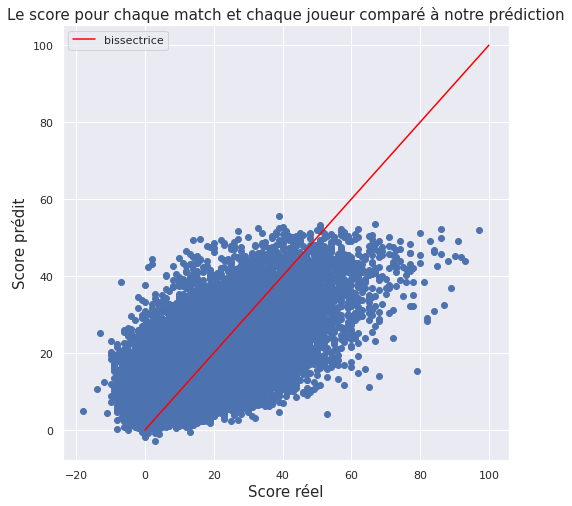

In [18]:
afficher_model(model, X, y)

### Lasso

In [19]:
model = Lasso(alpha=alpha_lasso)
model.fit(X,y)

R = model.score(X, y)
MAE = mean_absolute_error(model.predict(X), y)
print(f'R^2 = {R:.3}, MAE = {MAE:.3}')

R^2 = 0.393, MAE = 8.74


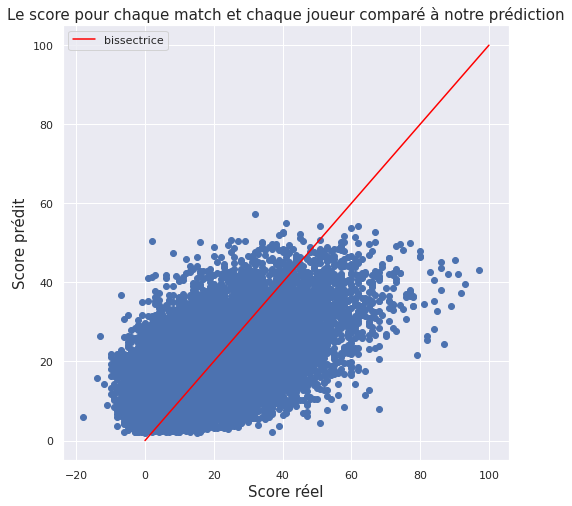

In [20]:
afficher_model(model, X, y)

### Prédictions

In [21]:
pred_rank = prediction_date('2020-02-10')
players_id2name(pred_rank.to_frame()).drop('PLAYER_ID', axis=1)

,NAME
0,Bojan Bogdanovic
1,LeBron James
2,Andrew Wiggins
3,Lonnie Walker IV
4,Malik Monk


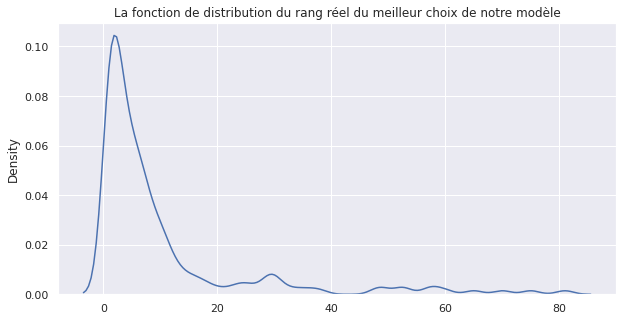

In [22]:
plt.figure(figsize=(10,5))

plt.title(label="La fonction de distribution du rang réel du meilleur choix de notre modèle")

sns.kdeplot(np.array(error), bw_method=0.1)
plt.show()

## 5 - Conclusions / Ouverture

- Prédiction absolue / prédiction relative
- Données supplémentaires sur l'adversaire
- Modèles non-linéaires
- Restreindre à une partie des joueurs (les plus gros score, les titulaires...)
- Optimisation sur la durée